In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [8]:

try:
    train = pd.read_csv('../data/train_clean.csv')
    test = pd.read_csv('../data/test_clean.csv')
    print("Datasets cargados exitosamente")
except FileNotFoundError:
    print("No se encontraron los archivos")
    exit()

print(f"✓ Dataset de entrenamiento: {train.shape}")
print(f"✓ Dataset de prueba: {test.shape}")

Datasets cargados exitosamente
✓ Dataset de entrenamiento: (7030723, 16)
✓ Dataset de prueba: (7027943, 16)


In [ ]:
# DESCRIPCIÓN GENERAL DEL DATASET

print("\n" + "="*80)
print("1. DESCRIPCIÓN GENERAL DEL DATASET")
print("="*80)

def analizar_dataset(df, nombre):
    print(f"\n DATASET {nombre.upper()}")
    print("-" * 50)
    
    print(f"Dimensiones: {df.shape[0]:,} observaciones x {df.shape[1]} variables")
    
    print(f"\nTipos de datos:")
    tipos = df.dtypes.value_counts()
    for tipo, count in tipos.items():
        print(f" {tipo}: {count} variables")
    
    memoria_mb = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\nMemoria utilizada: {memoria_mb:.2f} MB")

    print(f"\nDetalle de variables:")
    print(f"  Variables categóricas: user_id, merchant_id, age_range, gender, label")
    print(f"  Variables numéricas: activity_len, actions_*, unique_*, day_span, has_1111")
    print(f"  Variables temporales: date_min, date_max")
    
    return df.dtypes

print("\n Información detallada por dataset:")
tipos_train = analizar_dataset(train, "ENTRENAMIENTO")
tipos_test = analizar_dataset(test, "PRUEBA")

print(f"\n Comparación de estructuras:")
columnas_comunes = set(train.columns) & set(test.columns)
columnas_solo_train = set(train.columns) - set(test.columns)
columnas_solo_test = set(test.columns) - set(train.columns)

print(f" Columnas comunes: {len(columnas_comunes)}")
if columnas_solo_train:
    print(f" Solo en train: {list(columnas_solo_train)}")
if columnas_solo_test:
    print(f" Solo en test: {list(columnas_solo_test)}")


1. DESCRIPCIÓN GENERAL DEL DATASET

 Información detallada por dataset:

 DATASET ENTRENAMIENTO
--------------------------------------------------
Dimensiones: 7,030,723 observaciones x 16 variables

Tipos de datos:
 int64: 14 variables
 object: 2 variables

Memoria utilizada: 1649.24 MB

Detalle de variables:
  Variables categóricas: user_id, merchant_id, age_range, gender, label
  Variables numéricas: activity_len, actions_*, unique_*, day_span, has_1111
  Variables temporales: date_min, date_max

 DATASET PRUEBA
--------------------------------------------------
Dimensiones: 7,027,943 observaciones x 16 variables

Tipos de datos:
 int64: 13 variables
 object: 2 variables
 float64: 1 variables

Memoria utilizada: 1648.58 MB

Detalle de variables:
  Variables categóricas: user_id, merchant_id, age_range, gender, label
  Variables numéricas: activity_len, actions_*, unique_*, day_span, has_1111
  Variables temporales: date_min, date_max

 Comparación de estructuras:
 Columnas comunes:

In [ ]:

# ANÁLISIS DE VARIABLES NUMÉRICAS

variables_numericas = [
    'activity_len', 'actions_0', 'actions_2', 'actions_3',
    'unique_items', 'unique_categories', 'unique_brands', 
    'day_span', 'has_1111'
]

variables_ordinales = ['age_range', 'gender']

def estadisticas_descriptivas(df, variables, nombre_dataset):
    print(f"\n ESTADÍSTICAS DESCRIPTIVAS - {nombre_dataset.upper()}")
    print("-" * 60)
    
    # Seleccionar solo variables que existen en el dataset
    vars_disponibles = [var for var in variables if var in df.columns]
    
    if not vars_disponibles:
        print("No se encontraron variables numéricas")
        return

    stats = df[vars_disponibles].describe()
    
    stats_extra = pd.DataFrame({
        'missing': df[vars_disponibles].isnull().sum(),
        'missing_pct': (df[vars_disponibles].isnull().sum() / len(df) * 100),
        'zeros': (df[vars_disponibles] == 0).sum(),
        'zeros_pct': ((df[vars_disponibles] == 0).sum() / len(df) * 100)
    })

    print("\n Medidas de tendencia central y dispersion:")
    print(stats.round(3))
    
    print(f"\n Valores faltantes y ceros:")
    print(stats_extra.round(2))
    
    print(f"\n Análisis detallado por variable:")
    for var in vars_disponibles:
        serie = df[var].dropna()
        if len(serie) == 0:
            continue
            
        print(f"\n {var.upper()}:")
        print(f"    - Rango: [{serie.min():.1f}, {serie.max():.1f}]")
        print(f"    - Media: {serie.mean():.3f} ± {serie.std():.3f}")
        print(f"    - Mediana: {serie.median():.1f}")
        print(f"    - Valores únicos: {serie.nunique():,}")
        
        # Percentiles
        p25, p75 = serie.quantile([0.25, 0.75])
        iqr = p75 - p25
        print(f"    - IQR: {iqr:.3f} (Q1={p25:.1f}, Q3={p75:.1f})")
        
        # Detección de outliers usando IQR
        limite_inf = p25 - 1.5 * iqr
        limite_sup = p75 + 1.5 * iqr
        outliers = ((serie < limite_inf) | (serie > limite_sup)).sum()
        outliers_pct = outliers / len(serie) * 100
        print(f"    - Outliers potenciales: {outliers:,} ({outliers_pct:.2f}%)")

# Análizar train
estadisticas_descriptivas(train, variables_numericas, "ENTRENAMIENTO")

# Analizar test (solo si tiene las mismas variables)
estadisticas_descriptivas(test, variables_numericas, "PRUEBA")


 ESTADÍSTICAS DESCRIPTIVAS - ENTRENAMIENTO
------------------------------------------------------------

 Medidas de tendencia central y dispersion:
       activity_len    actions_0    actions_2    actions_3  unique_items  unique_categories  unique_brands     day_span     has_1111
count   7030723.000  7030723.000  7030723.000  7030723.000   7030723.000        7030723.000    7030723.000  7030723.000  7030723.000
mean          3.499        3.447        0.233        0.215         2.267              1.347          1.046        7.373        0.198
std           5.550       11.546        0.727        0.932         4.900              1.103          0.312       25.831        0.399
min           0.000        0.000        0.000        0.000         0.000              0.000          0.000        0.000        0.000
25%           1.000        1.000        0.000        0.000         1.000              1.000          1.000        0.000        0.000
50%           1.000        1.000        0.000       

In [ ]:

# ANÁLISIS DE VARIABLES CATEGÓRICAS

def analizar_categoricas(df, nombre_dataset):
    print(f"\n  VARIABLES CATEGÓRICAS - {nombre_dataset.upper()}")
    print("-" * 50)
    
    variables_cat = ['age_range', 'gender', 'label']
    
    for var in variables_cat:
        if var not in df.columns:
            continue
            
        print(f"\n  {var.upper()}:")
        
        conteos = df[var].value_counts(dropna=False)
        porcentajes = df[var].value_counts(normalize=True, dropna=False) * 100
        
        tabla = pd.DataFrame({
            'Conteo': conteos,
            'Porcentaje': porcentajes
        }).round(2)
        
        print(tabla)

        print(f"    - Valores únicos: {df[var].nunique()}")
        print(f"    - Valores nulos: {df[var].isnull().sum():,} ({df[var].isnull().sum()/len(df)*100:.2f}%)")

analizar_categoricas(train, "ENTRENAMIENTO")
analizar_categoricas(test, "PRUEBA")



  VARIABLES CATEGÓRICAS - ENTRENAMIENTO
--------------------------------------------------

  AGE_RANGE:
    Conteo  Porcentaje
3  1913722       27.22
4  1459923       20.76
0  1371222       19.50
5   752927       10.71
2   731938       10.41
6   655922        9.33
7   124493        1.77
8    20290        0.29
1      286        0.00
    - Valores únicos: 9
    - Valores nulos: 0 (0.00%)

  GENDER:
    Conteo  Porcentaje
0  5101730       72.56
1  1618110       23.01
2   310883        4.42
    - Valores únicos: 3
    - Valores nulos: 0 (0.00%)

  LABEL:
     Conteo  Porcentaje
-1  6769859       96.29
 0   244912        3.48
 1    15952        0.23
    - Valores únicos: 3
    - Valores nulos: 0 (0.00%)

  VARIABLES CATEGÓRICAS - PRUEBA
--------------------------------------------------

  AGE_RANGE:
    Conteo  Porcentaje
3  1916611       27.27
4  1460542       20.78
0  1364985       19.42
5   752608       10.71
2   733323       10.43
6   650358        9.25
7   128644        1.83
8    20

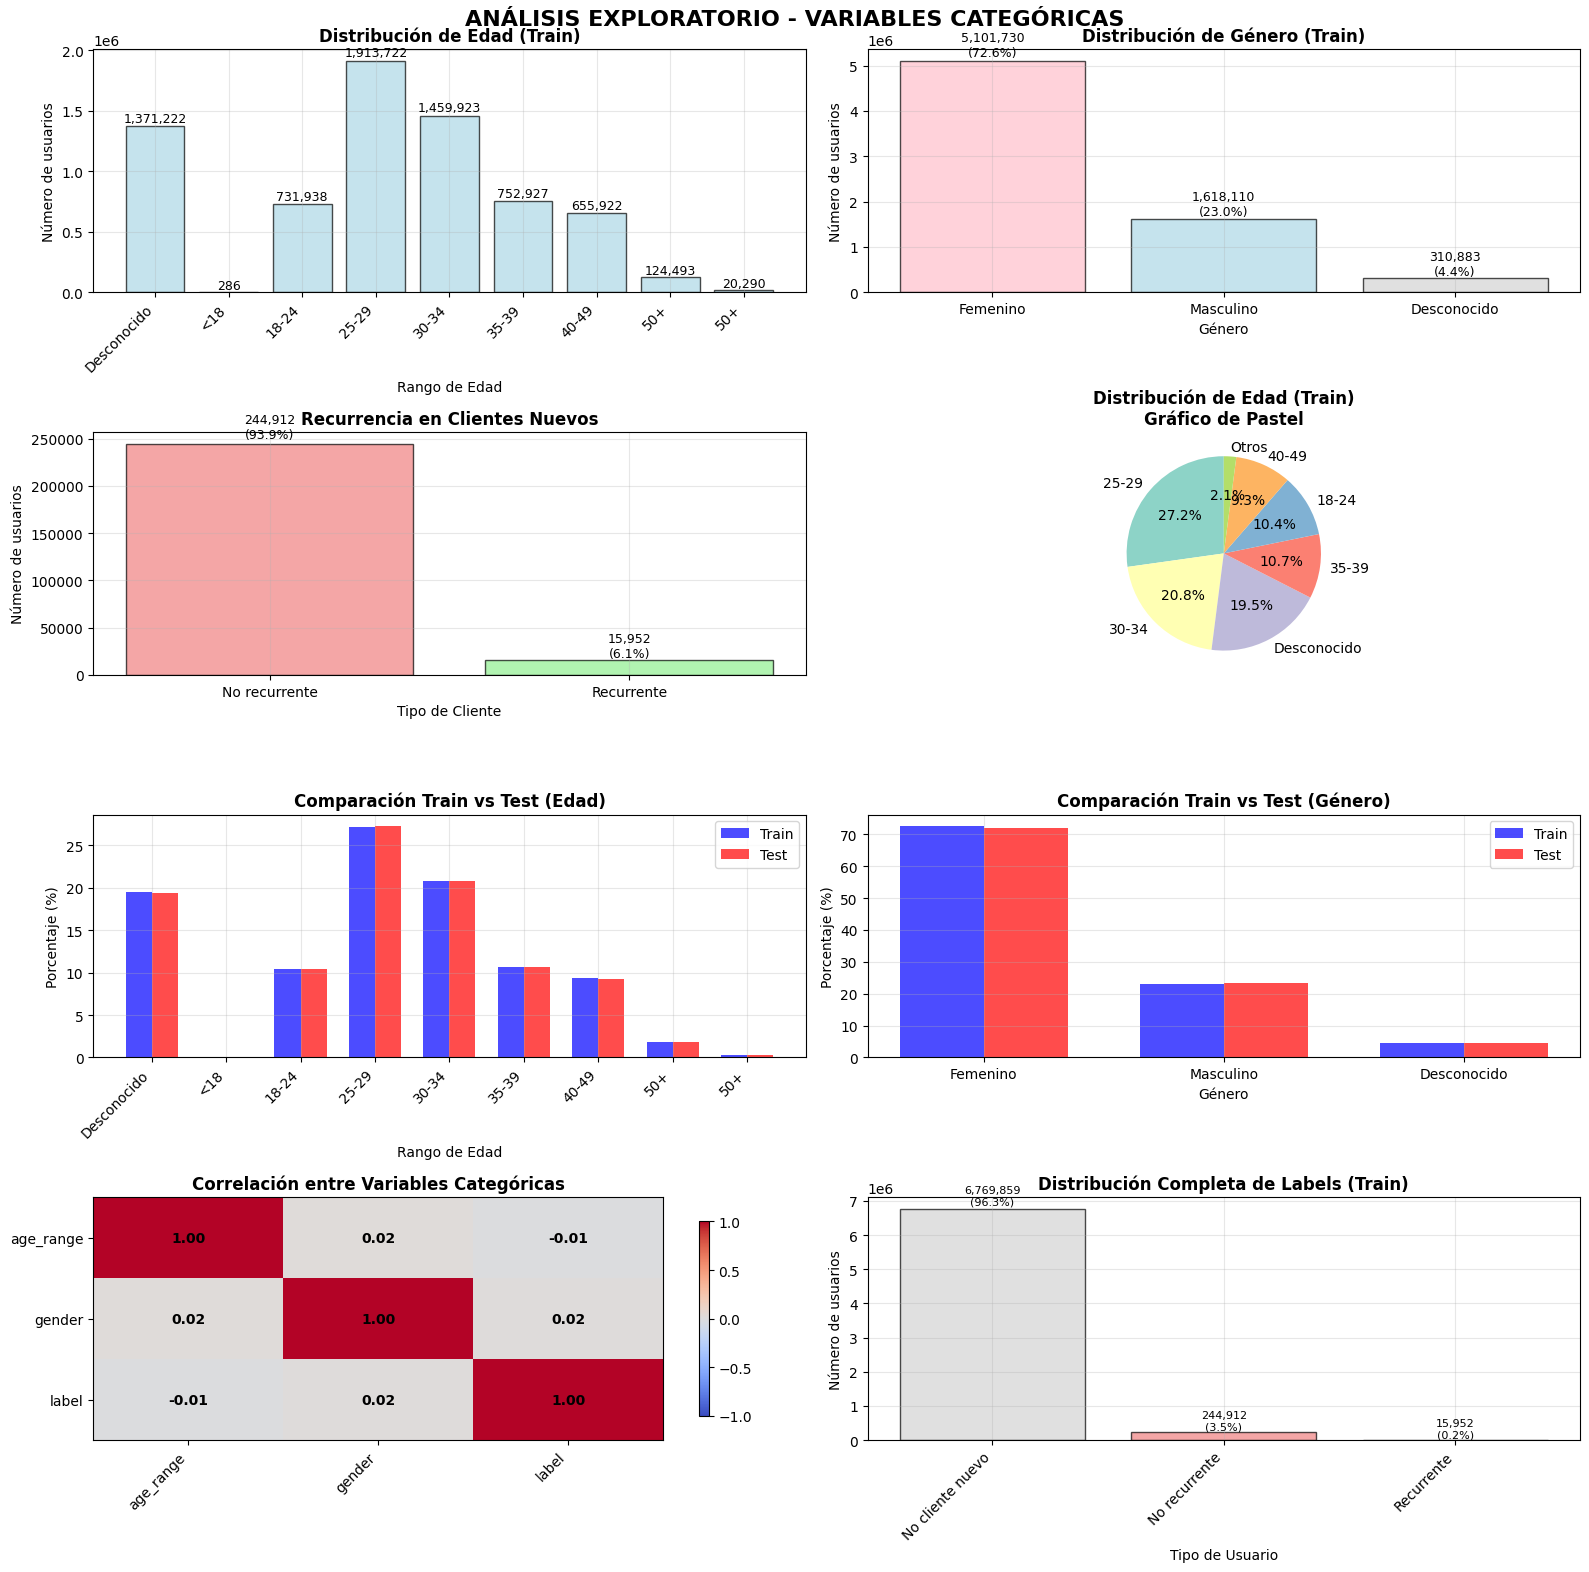


RESUMEN ESTADÍSTICO - VARIABLES CATEGÓRICAS

TRAIN:
------------------------------

  AGE_RANGE:
    • Total observaciones: 7,030,723
    • Valores válidos: 7,030,723 (100.0%)
    • Valores faltantes: 0 (0.0%)
    • Categorías únicas: 9
    • Categoría modal: 25-29 (1,913,722 obs, 27.2%)

  GENDER:
    • Total observaciones: 7,030,723
    • Valores válidos: 7,030,723 (100.0%)
    • Valores faltantes: 0 (0.0%)
    • Categorías únicas: 3
    • Categoría modal: Femenino (5,101,730 obs, 72.6%)

  LABEL:
    • Total observaciones: 7,030,723
    • Valores válidos: 7,030,723 (100.0%)
    • Valores faltantes: 0 (0.0%)
    • Categorías únicas: 3
    • Categoría modal: No cliente nuevo (6,769,859 obs, 96.3%)

TEST:
------------------------------

  AGE_RANGE:
    • Total observaciones: 7,027,943
    • Valores válidos: 7,027,943 (100.0%)
    • Valores faltantes: 0 (0.0%)
    • Categorías únicas: 9
    • Categoría modal: 25-29 (1,916,611 obs, 27.3%)

  GENDER:
    • Total observaciones: 7,027,943

In [11]:
# GRÁFICOS EXPLORATORIOS - VARIABLES CATEGÓRICAS (2 por fila)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir etiquetas para mejor interpretación
etiquetas_age = {
    0: 'Desconocido', 1: '<18', 2: '18-24', 3: '25-29',
    4: '30-34', 5: '35-39', 6: '40-49', 7: '50+', 8: '50+'
}

etiquetas_gender = {
    0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'
}

etiquetas_label = {
    -1: 'No cliente nuevo', 0: 'No recurrente', 1: 'Recurrente'
}

# Crear figura con diseño de 2 columnas
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
fig.suptitle('ANÁLISIS EXPLORATORIO - VARIABLES CATEGÓRICAS', fontsize=16, fontweight='bold')

# 1. Distribución de AGE_RANGE (Train)
ax = axes[0, 0]
if 'age_range' in train.columns:
    age_counts = train['age_range'].value_counts().sort_index()
    age_labels = [etiquetas_age.get(age, f'Age_{age}') for age in age_counts.index]
    
    bars = ax.bar(range(len(age_counts)), age_counts.values, 
                  color='lightblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Rango de Edad')
    ax.set_ylabel('Número de usuarios')
    ax.set_title('Distribución de Edad (Train)', fontweight='bold')
    ax.set_xticks(range(len(age_counts)))
    ax.set_xticklabels(age_labels, rotation=45, ha='right')
    
    # Agregar etiquetas con valores
    for bar, count in zip(bars, age_counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}', ha='center', va='bottom', fontsize=9)
    ax.grid(True, alpha=0.3)

# 2. Distribución de GENDER (Train)
ax = axes[0, 1]
if 'gender' in train.columns:
    gender_counts = train['gender'].value_counts().sort_index()
    gender_labels = [etiquetas_gender.get(gender, f'Gender_{gender}') for gender in gender_counts.index]
    colors = ['pink', 'lightblue', 'lightgray'][:len(gender_counts)]
    
    bars = ax.bar(range(len(gender_counts)), gender_counts.values,
                  color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Género')
    ax.set_ylabel('Número de usuarios')
    ax.set_title('Distribución de Género (Train)', fontweight='bold')
    ax.set_xticks(range(len(gender_counts)))
    ax.set_xticklabels(gender_labels, rotation=0)
    
    # Agregar etiquetas con porcentajes
    total_gender = gender_counts.sum()
    for bar, count in zip(bars, gender_counts.values):
        height = bar.get_height()
        pct = count / total_gender * 100
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)
    ax.grid(True, alpha=0.3)

# 3. Distribución de LABEL (Train) - solo clientes nuevos
ax = axes[1, 0]
if 'label' in train.columns:
    # Filtrar solo clientes nuevos (label 0 y 1)
    clientes_nuevos = train[train['label'].isin([0, 1])]
    if len(clientes_nuevos) > 0:
        label_counts = clientes_nuevos['label'].value_counts().sort_index()
        label_labels = [etiquetas_label.get(label, f'Label_{label}') for label in label_counts.index]
        colors = ['lightcoral', 'lightgreen']
        
        bars = ax.bar(range(len(label_counts)), label_counts.values,
                      color=colors, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Tipo de Cliente')
        ax.set_ylabel('Número de usuarios')
        ax.set_title('Recurrencia en Clientes Nuevos', fontweight='bold')
        ax.set_xticks(range(len(label_counts)))
        ax.set_xticklabels(label_labels, rotation=0)
        
        # Agregar etiquetas con porcentajes
        total_nuevos = label_counts.sum()
        for bar, count in zip(bars, label_counts.values):
            height = bar.get_height()
            pct = count / total_nuevos * 100
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)
        ax.grid(True, alpha=0.3)

# 4. Gráfico de pie para AGE_RANGE (Train)
ax = axes[1, 1]
if 'age_range' in train.columns:
    age_counts = train['age_range'].value_counts()
    age_labels = [etiquetas_age.get(age, f'Age_{age}') for age in age_counts.index]
    
    # Solo mostrar categorías con más del 2% para mejor visualización
    significant_ages = age_counts[age_counts / age_counts.sum() > 0.02]
    other_count = age_counts[age_counts / age_counts.sum() <= 0.02].sum()
    
    if other_count > 0:
        plot_counts = list(significant_ages.values) + [other_count]
        plot_labels = [etiquetas_age.get(age, f'Age_{age}') for age in significant_ages.index] + ['Otros']
    else:
        plot_counts = significant_ages.values
        plot_labels = [etiquetas_age.get(age, f'Age_{age}') for age in significant_ages.index]
    
    wedges, texts, autotexts = ax.pie(plot_counts, labels=plot_labels, autopct='%1.1f%%', 
                                      startangle=90, colors=plt.cm.Set3.colors)
    ax.set_title('Distribución de Edad (Train)\nGráfico de Pastel', fontweight='bold')

# 5. Comparación Train vs Test - AGE_RANGE
ax = axes[2, 0]
if 'age_range' in train.columns and 'age_range' in test.columns:
    age_train_pct = train['age_range'].value_counts(normalize=True).sort_index() * 100
    age_test_pct = test['age_range'].value_counts(normalize=True).sort_index() * 100
    
    # Asegurar que ambos tengan las mismas categorías
    all_ages = sorted(set(age_train_pct.index) | set(age_test_pct.index))
    train_values = [age_train_pct.get(age, 0) for age in all_ages]
    test_values = [age_test_pct.get(age, 0) for age in all_ages]
    age_labels = [etiquetas_age.get(age, f'Age_{age}') for age in all_ages]
    
    x = np.arange(len(all_ages))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train', alpha=0.7, color='blue')
    ax.bar(x + width/2, test_values, width, label='Test', alpha=0.7, color='red')
    
    ax.set_xlabel('Rango de Edad')
    ax.set_ylabel('Porcentaje (%)')
    ax.set_title('Comparación Train vs Test (Edad)', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(age_labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 6. Comparación Train vs Test - GENDER
ax = axes[2, 1]
if 'gender' in train.columns and 'gender' in test.columns:
    gender_train_pct = train['gender'].value_counts(normalize=True).sort_index() * 100
    gender_test_pct = test['gender'].value_counts(normalize=True).sort_index() * 100
    
    # Asegurar que ambos tengan las mismas categorías
    all_genders = sorted(set(gender_train_pct.index) | set(gender_test_pct.index))
    train_values = [gender_train_pct.get(gender, 0) for gender in all_genders]
    test_values = [gender_test_pct.get(gender, 0) for gender in all_genders]
    gender_labels = [etiquetas_gender.get(gender, f'Gender_{gender}') for gender in all_genders]
    
    x = np.arange(len(all_genders))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train', alpha=0.7, color='blue')
    ax.bar(x + width/2, test_values, width, label='Test', alpha=0.7, color='red')
    
    ax.set_xlabel('Género')
    ax.set_ylabel('Porcentaje (%)')
    ax.set_title('Comparación Train vs Test (Género)', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(gender_labels, rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3)

# 7. Heatmap de correlación entre variables categóricas
ax = axes[3, 0]
if all(col in train.columns for col in ['age_range', 'gender']):
    categorical_vars = ['age_range', 'gender']
    if 'label' in train.columns:
        categorical_vars.append('label')
    
    cat_data = train[categorical_vars].dropna()
    correlation_matrix = cat_data.corr()
    
    im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    
    # Agregar etiquetas
    ax.set_xticks(range(len(correlation_matrix.columns)))
    ax.set_yticks(range(len(correlation_matrix.columns)))
    ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(correlation_matrix.columns)
    
    # Agregar valores de correlación
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontweight='bold')
    
    ax.set_title('Correlación entre Variables Categóricas', fontweight='bold')
    
    # Agregar colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)

# 8. Distribución completa de LABEL (Train) - incluyendo -1
ax = axes[3, 1]
if 'label' in train.columns:
    all_labels = train['label'].value_counts().sort_index()
    all_label_names = [etiquetas_label.get(label, f'Label_{label}') for label in all_labels.index]
    colors = ['lightgray', 'lightcoral', 'lightgreen'][:len(all_labels)]
    
    bars = ax.bar(range(len(all_labels)), all_labels.values,
                  color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Tipo de Usuario')
    ax.set_ylabel('Número de usuarios')
    ax.set_title('Distribución Completa de Labels (Train)', fontweight='bold')
    ax.set_xticks(range(len(all_labels)))
    ax.set_xticklabels(all_label_names, rotation=45, ha='right')
    
    # Agregar etiquetas con porcentajes
    total_all = all_labels.sum()
    for bar, count in zip(bars, all_labels.values):
        height = bar.get_height()
        pct = count / total_all * 100
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla resumen de estadísticas categóricas
print("\n" + "="*70)
print("RESUMEN ESTADÍSTICO - VARIABLES CATEGÓRICAS")
print("="*70)

variables_cat = ['age_range', 'gender', 'label']

for dataset_name, df in [('TRAIN', train), ('TEST', test)]:
    print(f"\n{dataset_name}:")
    print("-" * 30)
    
    for var in variables_cat:
        if var not in df.columns:
            continue
        
        total_obs = len(df)
        valores_validos = df[var].notna().sum()
        valores_faltantes = df[var].isna().sum()
        categorias_unicas = df[var].nunique()
        
        print(f"\n  {var.upper()}:")
        print(f"    • Total observaciones: {total_obs:,}")
        print(f"    • Valores válidos: {valores_validos:,} ({valores_validos/total_obs*100:.1f}%)")
        print(f"    • Valores faltantes: {valores_faltantes:,} ({valores_faltantes/total_obs*100:.1f}%)")
        print(f"    • Categorías únicas: {categorias_unicas}")
        
        if valores_validos > 0:
            moda = df[var].mode()
            if len(moda) > 0:
                moda_value = moda.iloc[0]
                moda_count = (df[var] == moda_value).sum()
                moda_pct = moda_count / valores_validos * 100
                
                # Obtener etiqueta legible
                if var == 'age_range':
                    moda_label = etiquetas_age.get(moda_value, f'Age_{moda_value}')
                elif var == 'gender':
                    moda_label = etiquetas_gender.get(moda_value, f'Gender_{moda_value}')
                elif var == 'label':
                    moda_label = etiquetas_label.get(moda_value, f'Label_{moda_value}')
                else:
                    moda_label = str(moda_value)
                
                print(f"    • Categoría modal: {moda_label} ({moda_count:,} obs, {moda_pct:.1f}%)")

# Análisis específico para clientes nuevos
if 'label' in train.columns:
    clientes_nuevos = train[train['label'].isin([0, 1])]
    if len(clientes_nuevos) > 0:
        print(f"\n" + "="*50)
        print("ANÁLISIS ESPECÍFICO - CLIENTES NUEVOS")
        print("="*50)
        
        total_nuevos = len(clientes_nuevos)
        recurrentes = (clientes_nuevos['label'] == 1).sum()
        no_recurrentes = (clientes_nuevos['label'] == 0).sum()
        tasa_recurrencia = recurrentes / total_nuevos * 100
        
        print(f"\n  • Total clientes nuevos: {total_nuevos:,}")
        print(f"  • Recurrentes: {recurrentes:,} ({recurrentes/total_nuevos*100:.1f}%)")
        print(f"  • No recurrentes: {no_recurrentes:,} ({no_recurrentes/total_nuevos*100:.1f}%)")
        print(f"  • Tasa de recurrencia global: {tasa_recurrencia:.2f}%")
        print(f"  • Ratio desbalance (No rec.:Rec.): {no_recurrentes/recurrentes:.2f}:1")

In [ ]:
# ANÁLISIS DE VARIABLES TEMPORALES

def analizar_temporales(df, nombre_dataset):
    print(f"\n VARIABLES TEMPORALES - {nombre_dataset.upper()}")
    print("-" * 50)

    for col in ['date_min', 'date_max']:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    if 'date_min' in df.columns:
        fecha_min = df['date_min'].dropna()
        print(f"\n  • DATE_MIN:")
        if len(fecha_min) > 0:
            print(f"    - Rango: {fecha_min.min()} a {fecha_min.max()}")
            print(f"    - Valores no nulos: {len(fecha_min):,} ({len(fecha_min)/len(df)*100:.2f}%)")
            
            meses = fecha_min.dt.month.value_counts().sort_index()
            print(f"    - Distribución por mes: {dict(meses)}")
        else:
            print("    - No hay fechas válidas")
    
    if 'date_max' in df.columns:
        fecha_max = df['date_max'].dropna()
        print(f"\n  • DATE_MAX:")
        if len(fecha_max) > 0:
            print(f"    - Rango: {fecha_max.min()} a {fecha_max.max()}")
            print(f"    - Valores no nulos: {len(fecha_max):,} ({len(fecha_max)/len(df)*100:.2f}%)")
        else:
            print("    - No hay fechas válidas")
    
    if 'day_span' in df.columns:
        span = df['day_span'].dropna()
        print(f"\n  • DAY_SPAN (días entre primera y última interacción):")
        if len(span) > 0:
            print(f"    - Media: {span.mean():.2f} días")
            print(f"    - Mediana: {span.median():.0f} días")
            print(f"    - Máximo: {span.max():.0f} días")
            print(f"    - Usuarios con span = 0: {(span == 0).sum():,} ({(span == 0).sum()/len(span)*100:.2f}%)")
        else:
            print("    - No hay datos de span disponibles")

analizar_temporales(train, "ENTRENAMIENTO")
analizar_temporales(test, "PRUEBA")



 VARIABLES TEMPORALES - ENTRENAMIENTO
--------------------------------------------------

  • DATE_MIN:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7,027,748 (99.96%)
    - Distribución por mes: {5: 473191, 6: 876483, 7: 691220, 8: 704240, 9: 910835, 10: 1245551, 11: 2126228}

  • DATE_MAX:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7,027,748 (99.96%)

  • DAY_SPAN (días entre primera y última interacción):
    - Media: 7.37 días
    - Mediana: 0 días
    - Máximo: 184 días
    - Usuarios con span = 0: 5,630,998 (80.09%)

 VARIABLES TEMPORALES - PRUEBA
--------------------------------------------------

  • DATE_MIN:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7,024,937 (99.96%)
    - Distribución por mes: {5: 475364, 6: 875377, 7: 693543, 8: 701605, 9: 910088, 10: 1244282, 11: 2124678}

  • DATE_MAX:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7

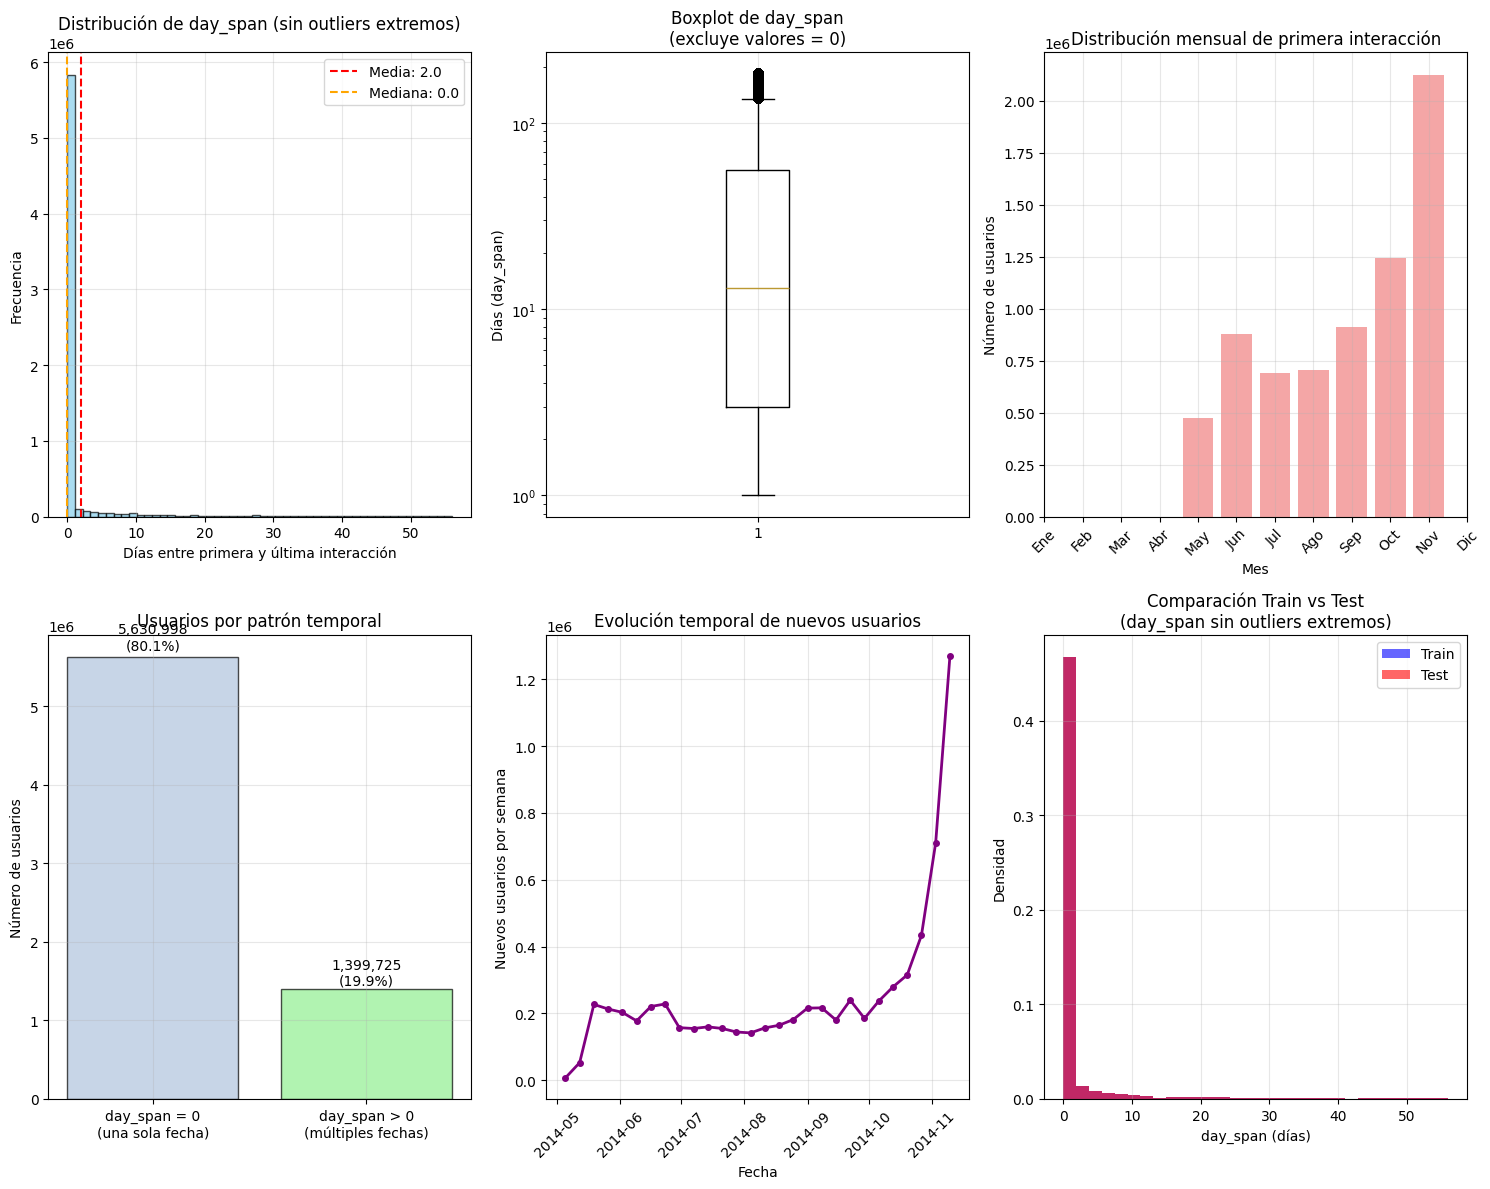


ESTADÍSTICAS ADICIONALES - VARIABLES TEMPORALES

DAY_SPAN - TRAIN:
  • Usuarios con una sola fecha (day_span=0): 5,630,998 (80.1%)
  • Usuarios con múltiples fechas (day_span>0): 1,399,725 (19.9%)
  • Entre usuarios con day_span > 0:
    - Promedio: 37.0 días
    - Mediana: 13.0 días
    - Rango: 1 - 184 días

DAY_SPAN - TEST:
  • Usuarios con una sola fecha (day_span=0): 5,626,484 (80.1%)
  • Usuarios con múltiples fechas (day_span>0): 1,401,459 (19.9%)


In [5]:
# GRÁFICOS EXPLORATORIOS - VARIABLES TEMPORALES

plt.figure(figsize=(15, 12))

# Convertir fechas si es necesario
for col in ['date_min', 'date_max']:
    if col in train.columns and train[col].dtype == 'object':
        train[col] = pd.to_datetime(train[col], errors='coerce')
    if col in test.columns and test[col].dtype == 'object':
        test[col] = pd.to_datetime(test[col], errors='coerce')

# 1. Histograma de day_span
plt.subplot(2, 3, 1)
if 'day_span' in train.columns:
    # Filtrar outliers extremos para mejor visualización
    day_span_clean = train['day_span'].dropna()
    day_span_clean = day_span_clean[day_span_clean <= day_span_clean.quantile(0.95)]
    
    plt.hist(day_span_clean, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(day_span_clean.mean(), color='red', linestyle='--', label=f'Media: {day_span_clean.mean():.1f}')
    plt.axvline(day_span_clean.median(), color='orange', linestyle='--', label=f'Mediana: {day_span_clean.median():.1f}')
    plt.xlabel('Días entre primera y última interacción')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de day_span (sin outliers extremos)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 2. Boxplot de day_span
plt.subplot(2, 3, 2)
if 'day_span' in train.columns:
    # Usar log scale para mejor visualización debido a outliers
    day_span_nonzero = train['day_span'].dropna()
    day_span_nonzero = day_span_nonzero[day_span_nonzero > 0]
    
    plt.boxplot(day_span_nonzero, vert=True)
    plt.ylabel('Días (day_span)')
    plt.title('Boxplot de day_span\n(excluye valores = 0)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

# 3. Distribución mensual de date_min
plt.subplot(2, 3, 3)
if 'date_min' in train.columns:
    fecha_min_valid = train['date_min'].dropna()
    if len(fecha_min_valid) > 0:
        monthly_counts = fecha_min_valid.dt.month.value_counts().sort_index()
        months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        
        plt.bar(monthly_counts.index, monthly_counts.values, color='lightcoral', alpha=0.7)
        plt.xlabel('Mes')
        plt.ylabel('Número de usuarios')
        plt.title('Distribución mensual de primera interacción')
        plt.xticks(range(1, 13), [months[i-1] for i in range(1, 13)], rotation=45)
        plt.grid(True, alpha=0.3)

# 4. Usuarios con day_span = 0 vs > 0
plt.subplot(2, 3, 4)
if 'day_span' in train.columns:
    span_data = train['day_span'].dropna()
    span_zero = (span_data == 0).sum()
    span_nonzero = (span_data > 0).sum()
    
    categories = ['day_span = 0\n(una sola fecha)', 'day_span > 0\n(múltiples fechas)']
    counts = [span_zero, span_nonzero]
    colors = ['lightsteelblue', 'lightgreen']
    
    bars = plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Número de usuarios')
    plt.title('Usuarios por patrón temporal')
    plt.xticks(rotation=0)
    
    # Agregar etiquetas con porcentajes
    total = span_zero + span_nonzero
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}\n({count/total*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    plt.grid(True, alpha=0.3)

# 5. Evolución temporal (si hay suficientes datos)
plt.subplot(2, 3, 5)
if 'date_min' in train.columns:
    fecha_min_valid = train['date_min'].dropna()
    if len(fecha_min_valid) > 0:
        # Agrupar por semana para ver tendencias
        weekly_data = fecha_min_valid.dt.to_period('W').value_counts().sort_index()
        
        if len(weekly_data) > 1:
            plt.plot(weekly_data.index.to_timestamp(), weekly_data.values, 
                    marker='o', linewidth=2, markersize=4, color='purple')
            plt.xlabel('Fecha')
            plt.ylabel('Nuevos usuarios por semana')
            plt.title('Evolución temporal de nuevos usuarios')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Datos insuficientes\npara mostrar evolución', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Evolución temporal')

# 6. Comparación train vs test (day_span)
plt.subplot(2, 3, 6)
if 'day_span' in train.columns and 'day_span' in test.columns:
    train_span = train['day_span'].dropna()
    test_span = test['day_span'].dropna()
    
    # Filtrar outliers para mejor visualización
    train_span_clean = train_span[train_span <= train_span.quantile(0.95)]
    test_span_clean = test_span[test_span <= test_span.quantile(0.95)]
    
    plt.hist(train_span_clean, bins=30, alpha=0.6, label='Train', color='blue', density=True)
    plt.hist(test_span_clean, bins=30, alpha=0.6, label='Test', color='red', density=True)
    plt.xlabel('day_span (días)')
    plt.ylabel('Densidad')
    plt.title('Comparación Train vs Test\n(day_span sin outliers extremos)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("\n" + "="*60)
print("ESTADÍSTICAS ADICIONALES - VARIABLES TEMPORALES")
print("="*60)

if 'day_span' in train.columns:
    span_train = train['day_span'].dropna()
    print(f"\nDAY_SPAN - TRAIN:")
    print(f"  • Usuarios con una sola fecha (day_span=0): {(span_train == 0).sum():,} ({(span_train == 0).mean()*100:.1f}%)")
    print(f"  • Usuarios con múltiples fechas (day_span>0): {(span_train > 0).sum():,} ({(span_train > 0).mean()*100:.1f}%)")
    
    if (span_train > 0).any():
        span_positivo = span_train[span_train > 0]
        print(f"  • Entre usuarios con day_span > 0:")
        print(f"    - Promedio: {span_positivo.mean():.1f} días")
        print(f"    - Mediana: {span_positivo.median():.1f} días")
        print(f"    - Rango: {span_positivo.min():.0f} - {span_positivo.max():.0f} días")

if 'day_span' in test.columns:
    span_test = test['day_span'].dropna()
    print(f"\nDAY_SPAN - TEST:")
    print(f"  • Usuarios con una sola fecha (day_span=0): {(span_test == 0).sum():,} ({(span_test == 0).mean()*100:.1f}%)")
    print(f"  • Usuarios con múltiples fechas (day_span>0): {(span_test > 0).sum():,} ({(span_test > 0).mean()*100:.1f}%)")

In [ ]:
# ANÁLISIS ESPECÍFICO DEL COMPORTAMIENTO DE USUARIOS

def analizar_comportamiento(df, nombre_dataset):
    print(f"\n COMPORTAMIENTO DE USUARIOS - {nombre_dataset.upper()}")
    print("-" * 50)
    
    if 'activity_len' in df.columns:
        print(f"\n  • NIVEL DE ACTIVIDAD:")
        
        df_temp = df.copy()
        df_temp['actividad_nivel'] = pd.cut(
            df_temp['activity_len'], 
            bins=[0, 1, 3, 10, float('inf')], 
            labels=['Baja (1)', 'Media (2-3)', 'Alta (4-10)', 'Muy Alta (>10)'],
            include_lowest=True
        )
        
        actividad_dist = df_temp['actividad_nivel'].value_counts()
        print(f"    Distribución por nivel:")
        for nivel, count in actividad_dist.items():
            pct = count / len(df_temp) * 100
            print(f"    - {nivel}: {count:,} ({pct:.2f}%)")
    
    acciones_cols = ['actions_0', 'actions_2', 'actions_3']
    acciones_disponibles = [col for col in acciones_cols if col in df.columns]
    
    if acciones_disponibles:
        print(f"\n  • TIPOS DE ACCIONES:")
        acciones_totales = df[acciones_disponibles].sum()
        acciones_pct = acciones_totales / acciones_totales.sum() * 100
        
        nombres_acciones = {
            'actions_0': 'Vistas/Clics',
            'actions_2': 'Carrito',
            'actions_3': 'Compras'
        }
        
        for col in acciones_disponibles:
            nombre = nombres_acciones.get(col, col)
            print(f"    - {nombre}: {acciones_totales[col]:,} ({acciones_pct[col]:.2f}%)")
    
    diversidad_cols = ['unique_items', 'unique_categories', 'unique_brands']
    diversidad_disponibles = [col for col in diversidad_cols if col in df.columns]
    
    if diversidad_disponibles:
        print(f"\n  • DIVERSIDAD DE INTERACCIONES:")
        for col in diversidad_disponibles:
            media = df[col].mean()
            mediana = df[col].median()
            print(f"    - {col.replace('unique_', '').title()}: μ={media:.2f}, mediana={mediana:.0f}")

analizar_comportamiento(train, "ENTRENAMIENTO")
analizar_comportamiento(test, "PRUEBA")


 COMPORTAMIENTO DE USUARIOS - ENTRENAMIENTO
--------------------------------------------------

  • NIVEL DE ACTIVIDAD:
    Distribución por nivel:
    - Baja (1): 3,633,744 (51.68%)
    - Media (2-3): 1,725,981 (24.55%)
    - Alta (4-10): 1,188,907 (16.91%)
    - Muy Alta (>10): 482,091 (6.86%)

  • TIPOS DE ACCIONES:
    - Vistas/Clics: 24,235,247 (88.50%)
    - Carrito: 1,636,724 (5.98%)
    - Compras: 1,512,086 (5.52%)

  • DIVERSIDAD DE INTERACCIONES:
    - Items: μ=2.27, mediana=1
    - Categories: μ=1.35, mediana=1
    - Brands: μ=1.05, mediana=1

 COMPORTAMIENTO DE USUARIOS - PRUEBA
--------------------------------------------------

  • NIVEL DE ACTIVIDAD:
    Distribución por nivel:
    - Baja (1): 3,628,073 (51.62%)
    - Media (2-3): 1,729,124 (24.60%)
    - Alta (4-10): 1,188,581 (16.91%)
    - Muy Alta (>10): 482,165 (6.86%)

  • TIPOS DE ACCIONES:
    - Vistas/Clics: 24,315,466 (88.58%)
    - Carrito: 1,640,984 (5.98%)
    - Compras: 1,493,637 (5.44%)

  • DIVERSIDAD DE

In [ ]:

# ANÁLISIS DE LA VARIABLE OBJETIVO (solo para train)

if 'label' in train.columns:
    print(f"\n VARIABLE OBJETIVO (LABEL) - ENTRENAMIENTO")
    print("-" * 50)
    
    label_counts = train['label'].value_counts(dropna=False)
    label_pcts = train['label'].value_counts(normalize=True, dropna=False) * 100
    
    print(f"\nDistribución completa:")
    for valor, count in label_counts.items():
        pct = label_pcts[valor]
        if valor == -1:
            descripcion = "(no son clientes nuevos - contexto)"
        elif valor == 0:
            descripcion = "(clientes nuevos, no recurrentes)"
        elif valor == 1:
            descripcion = "(clientes nuevos, recurrentes)"
        else:
            descripcion = ""
        
        print(f"  • Label {valor}: {count:,} ({pct:.2f}%) {descripcion}")
    
    clientes_nuevos = train[train['label'].isin([0, 1])]
    
    if len(clientes_nuevos) > 0:
        print(f"\nAnálisis para CLIENTES NUEVOS solamente:")
        print(f"  • Total clientes nuevos: {len(clientes_nuevos):,}")
        
        nuevos_counts = clientes_nuevos['label'].value_counts()
        nuevos_pcts = clientes_nuevos['label'].value_counts(normalize=True) * 100
        
        for valor, count in nuevos_counts.items():
            pct = nuevos_pcts[valor]
            tipo = "No recurrentes" if valor == 0 else "Recurrentes"
            print(f"  • {tipo}: {count:,} ({pct:.2f}%)")
        
        if 1 in nuevos_counts and 0 in nuevos_counts:
            ratio = nuevos_counts[0] / nuevos_counts[1]
            print(f"  • Ratio desbalance (0:1): {ratio:.2f}:1")
else:
    print("No se encontró la variable 'label' en el dataset de entrenamiento")




 VARIABLE OBJETIVO (LABEL) - ENTRENAMIENTO
--------------------------------------------------

Distribución completa:
  • Label -1: 6,769,859 (96.29%) (no son clientes nuevos - contexto)
  • Label 0: 244,912 (3.48%) (clientes nuevos, no recurrentes)
  • Label 1: 15,952 (0.23%) (clientes nuevos, recurrentes)

Análisis para CLIENTES NUEVOS solamente:
  • Total clientes nuevos: 260,864
  • No recurrentes: 244,912 (93.88%)
  • Recurrentes: 15,952 (6.12%)
  • Ratio desbalance (0:1): 15.35:1


In [ ]:
#  TABLAS DE FRECUENCIA PARA VARIABLES CATEGÓRICAS

def crear_tablas_frecuencia(df, nombre_dataset):
    print(f"\n TABLAS DE FRECUENCIA - {nombre_dataset.upper()}")
    print("-" * 60)
    
    variables_categoricas = {
        'age_range': {
            0: 'Desconocido',
            1: '<18 años', 
            2: '18-24 años',
            3: '25-29 años',
            4: '30-34 años', 
            5: '35-39 años',
            6: '40-49 años',
            7: '50+ años',
            8: '50+ años'
        },
        'gender': {
            0: 'Femenino',
            1: 'Masculino', 
            2: 'Desconocido'
        },
        'label': {
            -1: 'No cliente nuevo',
            0: 'No recurrente',
            1: 'Recurrente'
        }
    }
    
    for variable, etiquetas in variables_categoricas.items():
        if variable not in df.columns:
            continue
            
        print(f"\n TABLA DE FRECUENCIA: {variable.upper()}")
        print("-" * 40)
        
        frecuencias = df[variable].value_counts(dropna=False).sort_index()
        porcentajes = df[variable].value_counts(normalize=True, dropna=False).sort_index() * 100
        porcentajes_acum = porcentajes.cumsum()
        
        tabla_freq = pd.DataFrame({
            'Valor': frecuencias.index,
            'Etiqueta': [etiquetas.get(val, f'Valor_{val}') for val in frecuencias.index],
            'Frecuencia': frecuencias.values,
            'Porcentaje': porcentajes.values,
            'Porcentaje_Acum': porcentajes_acum.values
        })
        
        tabla_freq['Etiqueta'] = tabla_freq.apply(
            lambda row: 'Valores Faltantes' if pd.isna(row['Valor']) else row['Etiqueta'], 
            axis=1
        )
        
        print(tabla_freq.round(2).to_string(index=False))
        
        total_validos = df[variable].notna().sum()
        total_faltantes = df[variable].isna().sum()
        print(f"\nResumen estadístico:")
        print(f"  • Total observaciones: {len(df):,}")
        print(f"  • Valores válidos: {total_validos:,} ({total_validos/len(df)*100:.2f}%)")
        print(f"  • Valores faltantes: {total_faltantes:,} ({total_faltantes/len(df)*100:.2f}%)")
        print(f"  • Categorías únicas: {df[variable].nunique()}")
        
        if not frecuencias.empty:
            moda = frecuencias.idxmax()
            moda_etiqueta = etiquetas.get(moda, f'Valor_{moda}')
            moda_freq = frecuencias.max()
            moda_pct = porcentajes.max()
            print(f"  • Categoría modal: {moda_etiqueta} ({moda_freq:,} obs, {moda_pct:.2f}%)")

crear_tablas_frecuencia(train, "ENTRENAMIENTO")
crear_tablas_frecuencia(test, "PRUEBA")



 TABLAS DE FRECUENCIA - ENTRENAMIENTO
------------------------------------------------------------

 TABLA DE FRECUENCIA: AGE_RANGE
----------------------------------------
 Valor    Etiqueta  Frecuencia  Porcentaje  Porcentaje_Acum
     0 Desconocido     1371222       19.50            19.50
     1    <18 años         286        0.00            19.51
     2  18-24 años      731938       10.41            29.92
     3  25-29 años     1913722       27.22            57.14
     4  30-34 años     1459923       20.76            77.90
     5  35-39 años      752927       10.71            88.61
     6  40-49 años      655922        9.33            97.94
     7    50+ años      124493        1.77            99.71
     8    50+ años       20290        0.29           100.00

Resumen estadístico:
  • Total observaciones: 7,030,723
  • Valores válidos: 7,030,723 (100.00%)
  • Valores faltantes: 0 (0.00%)
  • Categorías únicas: 9
  • Categoría modal: 25-29 años (1,913,722 obs, 27.22%)

 TABLA DE FRE

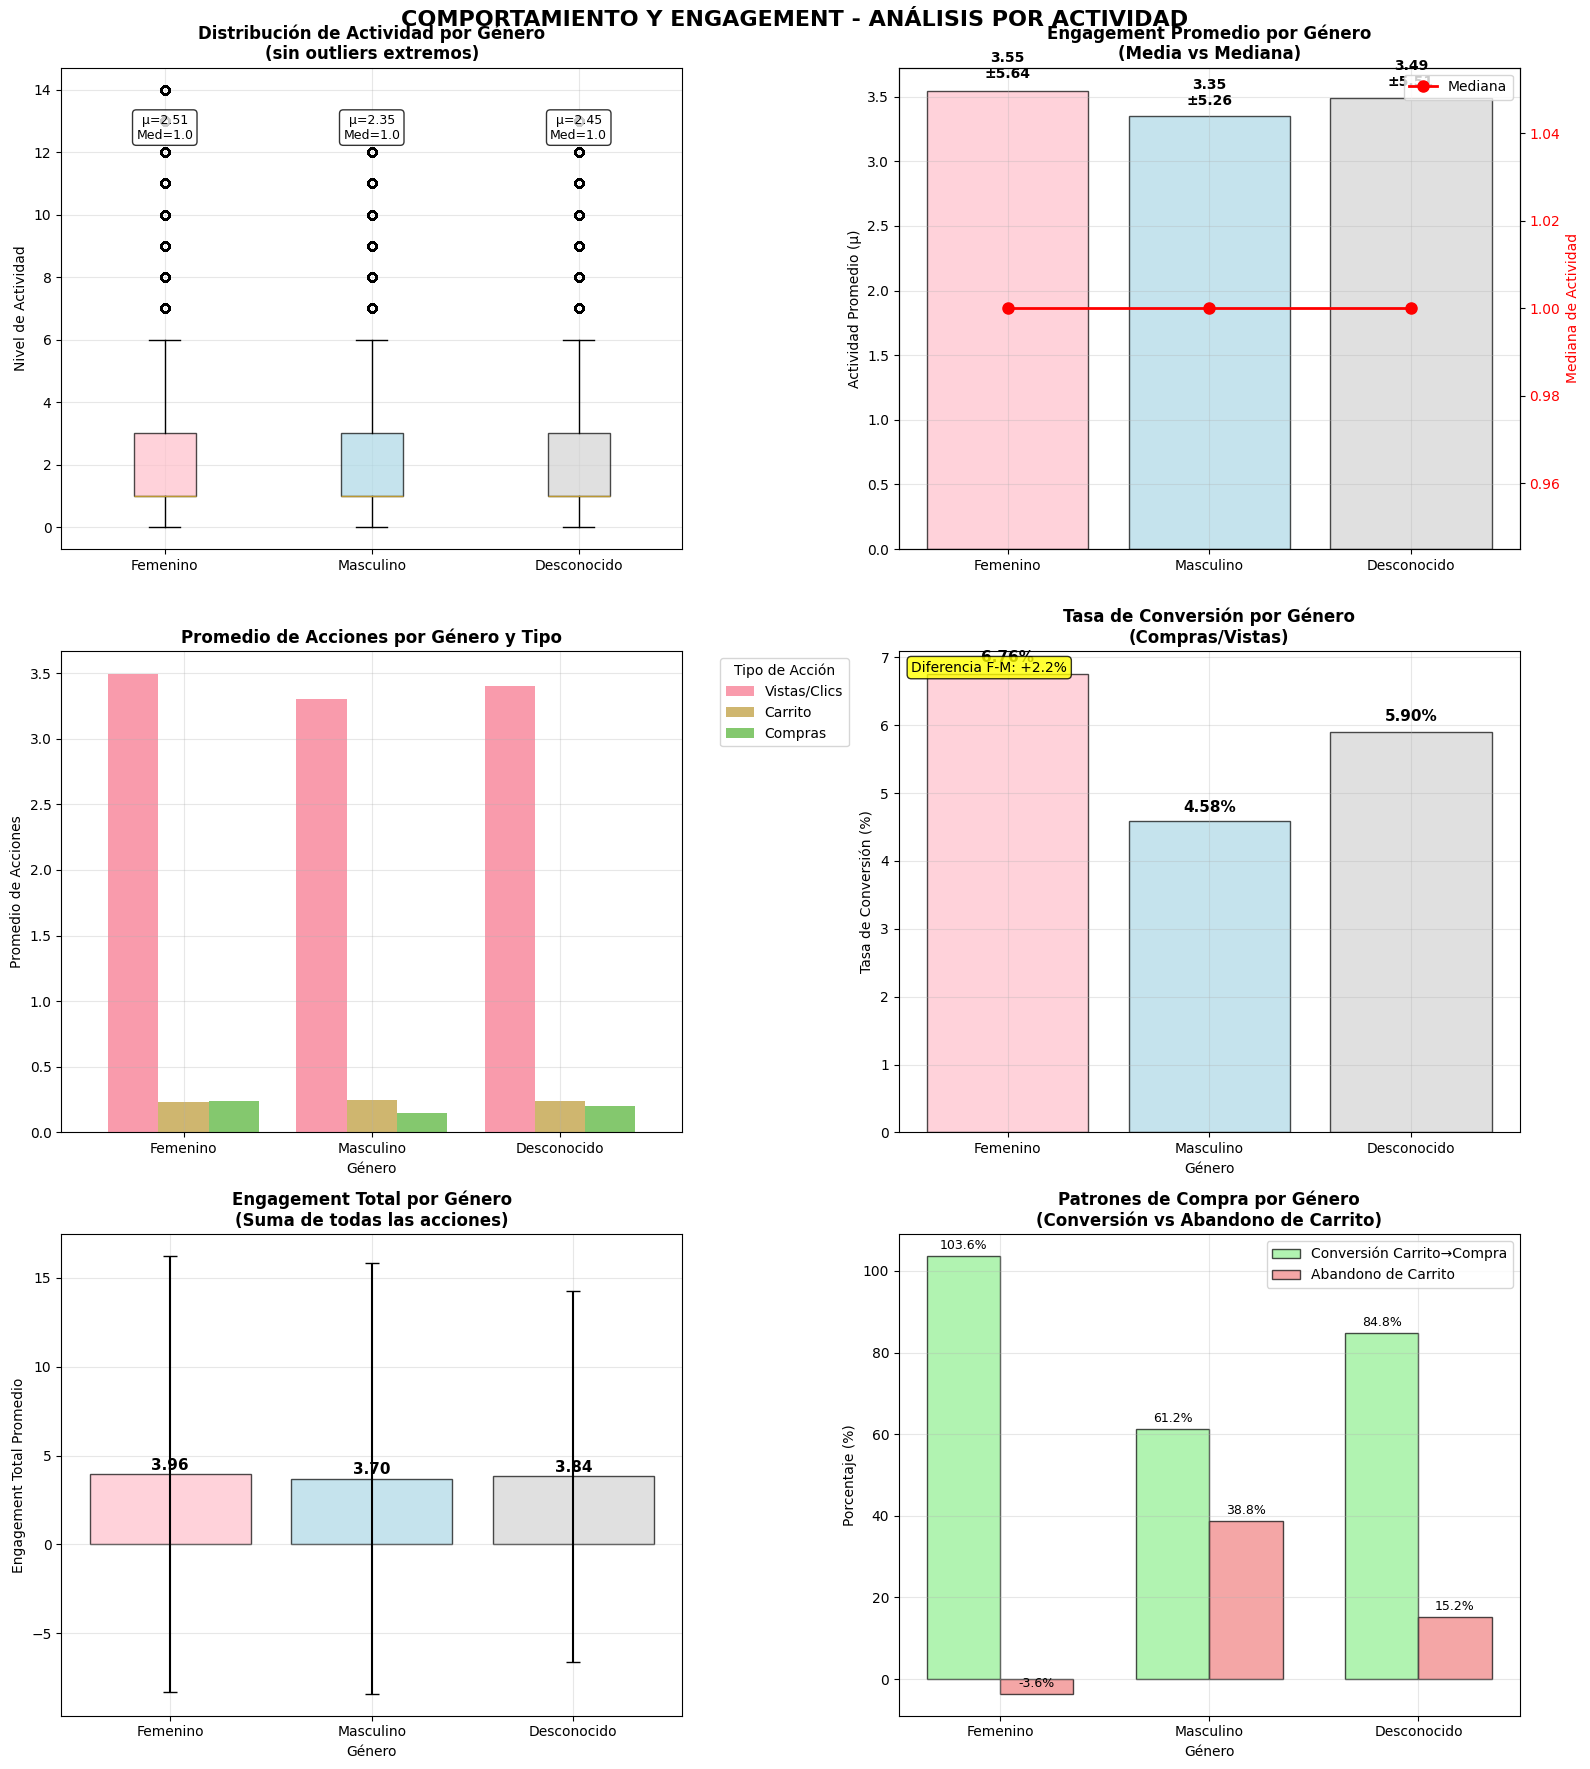


RESUMEN DETALLADO - COMPORTAMIENTO Y ENGAGEMENT POR GÉNERO

📊 FEMENINO (5,101,730 usuarios)
--------------------------------------------------
🎯 ACTIVIDAD GENERAL:
   • Promedio: 3.55 ± 5.64
   • Mediana: 1.0
   • Rango: [0, 37]

🛍️ TIPOS DE ACCIONES:
   • Vistas/Clics: μ=3.49, Total=17,829,247
   • Carrito: μ=0.23, Total=1,162,719
   • Compras: μ=0.24, Total=1,204,613

💰 CONVERSIÓN:
   • Tasa Vistas→Compras: 6.76%
   • Tasa Carrito→Compras: 103.60%
   • Tasa Abandono Carrito: -3.60%

🔥 ENGAGEMENT TOTAL: 3.96 acciones promedio

📊 MASCULINO (1,618,110 usuarios)
--------------------------------------------------
🎯 ACTIVIDAD GENERAL:
   • Promedio: 3.35 ± 5.26
   • Mediana: 1.0
   • Rango: [0, 37]

🛍️ TIPOS DE ACCIONES:
   • Vistas/Clics: μ=3.31, Total=5,348,491
   • Carrito: μ=0.25, Total=400,347
   • Compras: μ=0.15, Total=245,038

💰 CONVERSIÓN:
   • Tasa Vistas→Compras: 4.58%
   • Tasa Carrito→Compras: 61.21%
   • Tasa Abandono Carrito: 38.79%

🔥 ENGAGEMENT TOTAL: 3.70 acciones promed

In [ ]:
# GRÁFICOS DE COMPORTAMIENTO Y ENGAGEMENT POR ACTIVIDAD

# Definir etiquetas para interpretación
etiquetas_gender = {0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'}

# Preparar datos de actividad por género
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('COMPORTAMIENTO Y ENGAGEMENT - ANÁLISIS POR ACTIVIDAD', fontsize=16, fontweight='bold')

# 1. Distribución de activity_len por género
ax = axes[0, 0]
if 'activity_len' in train.columns and 'gender' in train.columns:
    activity_data = []
    gender_labels = []
    
    for gender_code in sorted(train['gender'].dropna().unique()):
        subset = train[train['gender'] == gender_code]['activity_len'].dropna()
        # Filtrar outliers para mejor visualización
        subset_clean = subset[subset <= subset.quantile(0.95)]
        activity_data.append(subset_clean)
        gender_labels.append(etiquetas_gender.get(gender_code, f'Gender_{gender_code}'))
    
    bp = ax.boxplot(activity_data, labels=gender_labels, patch_artist=True)
    colors = ['pink', 'lightblue', 'lightgray']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Nivel de Actividad')
    ax.set_title('Distribución de Actividad por Género\n(sin outliers extremos)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Agregar estadísticas como texto
    for i, data in enumerate(activity_data):
        if len(data) > 0:
            mean_val = data.mean()
            median_val = data.median()
            ax.text(i+1, ax.get_ylim()[1]*0.9, f'μ={mean_val:.2f}\nMed={median_val:.1f}', 
                   ha='center', va='top', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Engagement promedio por género (activity_len)
ax = axes[0, 1]
if 'activity_len' in train.columns and 'gender' in train.columns:
    engagement_stats = train.groupby('gender')['activity_len'].agg(['mean', 'median', 'std']).reset_index()
    engagement_stats['gender_label'] = engagement_stats['gender'].map(etiquetas_gender)
    
    bars = ax.bar(engagement_stats['gender_label'], engagement_stats['mean'], 
                  color=['pink', 'lightblue', 'lightgray'][:len(engagement_stats)], 
                  alpha=0.7, edgecolor='black')
    
    # Agregar línea de mediana
    ax2 = ax.twinx()
    ax2.plot(engagement_stats['gender_label'], engagement_stats['median'], 
             'ro-', linewidth=2, markersize=8, label='Mediana')
    ax2.set_ylabel('Mediana de Actividad', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_ylabel('Actividad Promedio (μ)')
    ax.set_title('Engagement Promedio por Género\n(Media vs Mediana)', fontweight='bold')
    
    # Agregar valores en las barras
    for bar, mean_val, std_val in zip(bars, engagement_stats['mean'], engagement_stats['std']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{mean_val:.2f}\n±{std_val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')

# 3. Análisis de acciones por género (actions_0, actions_2, actions_3)
ax = axes[1, 0]
acciones_cols = ['actions_0', 'actions_2', 'actions_3']
acciones_disponibles = [col for col in acciones_cols if col in train.columns]

if acciones_disponibles and 'gender' in train.columns:
    nombres_acciones = {
        'actions_0': 'Vistas/Clics',
        'actions_2': 'Carrito', 
        'actions_3': 'Compras'
    }
    
    # Calcular promedio de acciones por género
    acciones_por_genero = train.groupby('gender')[acciones_disponibles].mean()
    acciones_por_genero.index = acciones_por_genero.index.map(etiquetas_gender)
    
    # Renombrar columnas
    acciones_por_genero.columns = [nombres_acciones.get(col, col) for col in acciones_por_genero.columns]
    
    acciones_por_genero.plot(kind='bar', ax=ax, alpha=0.7, width=0.8)
    ax.set_ylabel('Promedio de Acciones')
    ax.set_title('Promedio de Acciones por Género y Tipo', fontweight='bold')
    ax.set_xlabel('Género')
    ax.legend(title='Tipo de Acción', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=0)

# 4. Tasa de conversión por género (Compras/Vistas)
ax = axes[1, 1]
if 'actions_0' in train.columns and 'actions_3' in train.columns and 'gender' in train.columns:
    # Calcular tasa de conversión por género
    conversion_data = []
    gender_labels_conv = []
    
    for gender_code in sorted(train['gender'].dropna().unique()):
        subset = train[train['gender'] == gender_code]
        total_vistas = subset['actions_0'].sum()
        total_compras = subset['actions_3'].sum()
        
        if total_vistas > 0:
            conversion_rate = (total_compras / total_vistas) * 100
        else:
            conversion_rate = 0
            
        conversion_data.append(conversion_rate)
        gender_labels_conv.append(etiquetas_gender.get(gender_code, f'Gender_{gender_code}'))
    
    bars = ax.bar(gender_labels_conv, conversion_data, 
                  color=['pink', 'lightblue', 'lightgray'][:len(conversion_data)], 
                  alpha=0.7, edgecolor='black')
    
    ax.set_ylabel('Tasa de Conversión (%)')
    ax.set_title('Tasa de Conversión por Género\n(Compras/Vistas)', fontweight='bold')
    ax.set_xlabel('Género')
    
    # Agregar valores en las barras
    for bar, rate in zip(bars, conversion_data):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{rate:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    
    # Calcular diferencia entre géneros
    if len(conversion_data) >= 2:
        diff_fem_masc = conversion_data[0] - conversion_data[1]  # Femenino - Masculino
        ax.text(0.02, 0.98, f'Diferencia F-M: {diff_fem_masc:+.1f}%', 
                transform=ax.transAxes, va='top', ha='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))

# 5. Engagement total por género (suma de todas las acciones)
ax = axes[2, 0]
if acciones_disponibles and 'gender' in train.columns:
    # Calcular engagement total por usuario
    train_temp = train.copy()
    train_temp['engagement_total'] = train_temp[acciones_disponibles].sum(axis=1)
    
    engagement_by_gender = train_temp.groupby('gender')['engagement_total'].agg(['mean', 'median', 'std'])
    engagement_by_gender.index = engagement_by_gender.index.map(etiquetas_gender)
    
    # Crear gráfico de barras con error bars
    bars = ax.bar(engagement_by_gender.index, engagement_by_gender['mean'], 
                  yerr=engagement_by_gender['std'], 
                  color=['pink', 'lightblue', 'lightgray'][:len(engagement_by_gender)], 
                  alpha=0.7, edgecolor='black', capsize=5)
    
    ax.set_ylabel('Engagement Total Promedio')
    ax.set_title('Engagement Total por Género\n(Suma de todas las acciones)', fontweight='bold')
    ax.set_xlabel('Género')
    
    # Agregar valores en las barras
    for bar, mean_val in zip(bars, engagement_by_gender['mean']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{mean_val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.grid(True, alpha=0.3)

# 6. Comparación de patrones de compra por género (Carrito vs Compras)
ax = axes[2, 1]
if 'actions_2' in train.columns and 'actions_3' in train.columns and 'gender' in train.columns:
    # Calcular ratios por género
    ratio_data = []
    abandono_data = []
    gender_labels_extended = []
    
    for gender_code in sorted(train['gender'].dropna().unique()):
        subset = train[train['gender'] == gender_code]
        total_carrito = subset['actions_2'].sum()
        total_compras = subset['actions_3'].sum()
        
        if total_carrito > 0:
            ratio_compra_carrito = (total_compras / total_carrito) * 100
            tasa_abandono = ((total_carrito - total_compras) / total_carrito) * 100
        else:
            ratio_compra_carrito = 0
            tasa_abandono = 0
            
        ratio_data.append(ratio_compra_carrito)
        abandono_data.append(tasa_abandono)
        gender_labels_extended.append(etiquetas_gender.get(gender_code, f'Gender_{gender_code}'))
    
    x = np.arange(len(gender_labels_extended))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, ratio_data, width, label='Conversión Carrito→Compra', 
                   color='lightgreen', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, abandono_data, width, label='Abandono de Carrito', 
                   color='lightcoral', alpha=0.7, edgecolor='black')
    
    ax.set_ylabel('Porcentaje (%)')
    ax.set_title('Patrones de Compra por Género\n(Conversión vs Abandono de Carrito)', fontweight='bold')
    ax.set_xlabel('Género')
    ax.set_xticks(x)
    ax.set_xticklabels(gender_labels_extended)
    ax.legend()
    
    # Agregar valores en las barras
    for bars, data in [(bars1, ratio_data), (bars2, abandono_data)]:
        for bar, value in zip(bars, data):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# RESUMEN ESTADÍSTICO DETALLADO
print("\n" + "="*80)
print("RESUMEN DETALLADO - COMPORTAMIENTO Y ENGAGEMENT POR GÉNERO")
print("="*80)

if 'gender' in train.columns:
    for gender_code in sorted(train['gender'].dropna().unique()):
        gender_name = etiquetas_gender.get(gender_code, f'Gender_{gender_code}')
        subset = train[train['gender'] == gender_code]
        
        print(f"\n📊 {gender_name.upper()} ({len(subset):,} usuarios)")
        print("-" * 50)
        
        # Actividad general
        if 'activity_len' in subset.columns:
            activity_subset = subset['activity_len'].dropna()
            print(f"🎯 ACTIVIDAD GENERAL:")
            print(f"   • Promedio: {activity_subset.mean():.2f} ± {activity_subset.std():.2f}")
            print(f"   • Mediana: {activity_subset.median():.1f}")
            print(f"   • Rango: [{activity_subset.min():.0f}, {activity_subset.max():.0f}]")
        
        # Análisis de acciones específicas
        if acciones_disponibles:
            print(f"\n🛍️ TIPOS DE ACCIONES:")
            for col in acciones_disponibles:
                nombre_accion = nombres_acciones.get(col, col)
                promedio = subset[col].mean()
                total = subset[col].sum()
                print(f"   • {nombre_accion}: μ={promedio:.2f}, Total={total:,}")
        
        # Tasas de conversión
        if 'actions_0' in subset.columns and 'actions_3' in subset.columns:
            total_vistas = subset['actions_0'].sum()
            total_compras = subset['actions_3'].sum()
            if total_vistas > 0:
                tasa_conversion = (total_compras / total_vistas) * 100
                print(f"\n💰 CONVERSIÓN:")
                print(f"   • Tasa Vistas→Compras: {tasa_conversion:.2f}%")
        
        if 'actions_2' in subset.columns and 'actions_3' in subset.columns:
            total_carrito = subset['actions_2'].sum()
            total_compras = subset['actions_3'].sum()
            if total_carrito > 0:
                tasa_carrito_compra = (total_compras / total_carrito) * 100
                tasa_abandono = ((total_carrito - total_compras) / total_carrito) * 100
                print(f"   • Tasa Carrito→Compras: {tasa_carrito_compra:.2f}%")
                print(f"   • Tasa Abandono Carrito: {tasa_abandono:.2f}%")
        
        # Engagement total
        if acciones_disponibles:
            engagement_total = subset[acciones_disponibles].sum(axis=1).mean()
            print(f"\n🔥 ENGAGEMENT TOTAL: {engagement_total:.2f} acciones promedio")

# Comparaciones entre géneros
if len(train['gender'].unique()) >= 2:
    print(f"\n" + "="*60)
    print("COMPARACIONES CLAVE ENTRE GÉNEROS")
    print("="*60)
    
    # Comparar actividad
    if 'activity_len' in train.columns:
        activity_by_gender = train.groupby('gender')['activity_len'].mean()
        fem_activity = activity_by_gender.get(0, 0)
        masc_activity = activity_by_gender.get(1, 0)
        
        if fem_activity > 0 and masc_activity > 0:
            diff_activity = ((fem_activity - masc_activity) / masc_activity) * 100
            print(f"\n🎯 DIFERENCIA EN ACTIVIDAD:")
            print(f"   • Mujeres vs Hombres: {diff_activity:+.1f}%")
    
    # Comparar conversión
    if 'actions_0' in train.columns and 'actions_3' in train.columns:
        print(f"\n💰 DIFERENCIAS EN CONVERSIÓN:")
        for gender_code in [0, 1]:  # Femenino y Masculino
            subset = train[train['gender'] == gender_code]
            total_vistas = subset['actions_0'].sum()
            total_compras = subset['actions_3'].sum()
            if total_vistas > 0:
                conversion_rate = (total_compras / total_vistas) * 100
                gender_name = etiquetas_gender.get(gender_code, f'Gender_{gender_code}')
                print(f"   • {gender_name}: {conversion_rate:.2f}% conversión vistas→compras")
        
        # Calcular diferencia porcentual
        fem_subset = train[train['gender'] == 0]
        masc_subset = train[train['gender'] == 1]
        
        fem_vistas = fem_subset['actions_0'].sum()
        fem_compras = fem_subset['actions_3'].sum()
        masc_vistas = masc_subset['actions_0'].sum()
        masc_compras = masc_subset['actions_3'].sum()
        
        if fem_vistas > 0 and masc_vistas > 0:
            fem_conv = (fem_compras / fem_vistas) * 100
            masc_conv = (masc_compras / masc_vistas) * 100
            diff_conv = ((fem_conv - masc_conv) / masc_conv) * 100
            print(f"   • Ventaja femenina en conversión: {diff_conv:+.1f}%")

print(f"\n" + "="*80)
print("INSIGHTS CLAVE DEL ANÁLISIS DE COMPORTAMIENTO")

In [ ]:

#  CRUCES ESPECÍFICOS CON VARIABLE OBJETIVO (solo TRAIN)

if 'label' in train.columns:
    clientes_nuevos = train[train['label'].isin([0, 1])]
    
    if len(clientes_nuevos) > 0:
        print(f"\n ANÁLISIS DE PATRONES EN CLIENTES NUEVOS")
        print(f"   (Excluye registros con label = -1)")
        print("-" * 50)
        
        # 1. RECURRENCIA vs GÉNERO
        if 'gender' in clientes_nuevos.columns:
            print(f"\n1️ RECURRENCIA vs GÉNERO")
            print("-" * 25)
            
            tabla_label_gender = pd.crosstab(
                clientes_nuevos['label'],
                clientes_nuevos['gender'],
                margins=True,
                margins_name='TOTAL'
            )
            print("Frecuencias absolutas:")
            print(tabla_label_gender)
            
            tasas_recurrencia = pd.crosstab(
            clientes_nuevos['label'],
            clientes_nuevos['gender'],
            normalize='columns'
        ).loc[1] * 100

        print(f"\nTasa de recurrencia por género:")

        # Se usa .to_series().replace() para evitar el TypeError
        tasas_recurrencia.index = tasas_recurrencia.index.to_series().replace({
            0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'
        })

        for genero, tasa in tasas_recurrencia.items():
            print(f"  • {genero}: {tasa:.2f}%")
        
        # 2. RECURRENCIA vs EDAD
        if 'age_range' in clientes_nuevos.columns:
            print(f"\n2️ RECURRENCIA vs RANGO DE EDAD")
            print("-" * 30)

            tasas_edad = pd.crosstab(
                clientes_nuevos['label'],
                clientes_nuevos['age_range'],
                normalize='columns'
            ).loc[1] * 100
            
            print(f"Tasa de recurrencia por grupo etario:")
            etiquetas_edad = {
                0: 'Desconocido', 1: '<18', 2: '18-24', 3: '25-29',
                4: '30-34', 5: '35-39', 6: '40-49', 7: '50+', 8: '50+'
            }
            
            for edad, tasa in tasas_edad.items():
                etiqueta = etiquetas_edad.get(edad, f'Edad_{edad}')
                print(f"  • {etiqueta}: {tasa:.2f}%")
        
        # 3. RECURRENCIA vs NIVEL DE ACTIVIDAD
        if 'activity_len' in clientes_nuevos.columns:
            print(f"\n3️  RECURRENCIA vs NIVEL DE ACTIVIDAD")
            print("-" * 35)
            
            stats_actividad = clientes_nuevos.groupby('label')['activity_len'].agg([
                'count', 'mean', 'std', 'median', 'min', 'max'
            ]).round(3)
            
            stats_actividad.index = stats_actividad.index.map({
                0: 'No Recurrentes', 1: 'Recurrentes'
            })
            
            print("Estadísticas de actividad por tipo de cliente:")
            print(stats_actividad)
            
            no_recurrentes = clientes_nuevos[clientes_nuevos['label'] == 0]['activity_len']
            recurrentes = clientes_nuevos[clientes_nuevos['label'] == 1]['activity_len']
            
            if len(no_recurrentes) > 0 and len(recurrentes) > 0:
                diff_medias = recurrentes.mean() - no_recurrentes.mean()
                print(f"\nDiferencia de medias (Recurrentes - No Recurrentes): {diff_medias:.3f}")
                
                if diff_medias > 0:
                    print("  → Los clientes recurrentes tienden a tener MÁS actividad")
                else:
                    print("  → Los clientes recurrentes tienden a tener MENOS actividad")



 ANÁLISIS DE PATRONES EN CLIENTES NUEVOS
   (Excluye registros con label = -1)
--------------------------------------------------

1️ RECURRENCIA vs GÉNERO
-------------------------
Frecuencias absolutas:
gender       0      1      2   TOTAL
label                               
0       165027  69787  10098  244912
1        11387   3969    596   15952
TOTAL   176414  73756  10694  260864

Tasa de recurrencia por género:
  • Femenino: 6.45%
  • Masculino: 5.38%
  • Desconocido: 5.57%

2️ RECURRENCIA vs RANGO DE EDAD
------------------------------
Tasa de recurrencia por grupo etario:
  • Desconocido: 5.82%
  • <18: 0.00%
  • 18-24: 4.93%
  • 25-29: 5.88%
  • 30-34: 6.72%
  • 35-39: 7.00%
  • 40-49: 6.83%
  • 50+: 6.04%
  • 50+: 6.94%

3️  RECURRENCIA vs NIVEL DE ACTIVIDAD
-----------------------------------
Estadísticas de actividad por tipo de cliente:
                 count    mean     std  median  min  max
label                                                   
No Recurrentes  24491

Basado en el análisis de los clientes, se han identificado varios patrones clave que diferencian a los clientes recurrentes de los que no lo son. En primer lugar, al examinar la relación entre la recurrencia y el género, se observa que la tasa de recurrencia en mujeres es notablemente superior a la de los hombres. Este dato sugiere que la fidelización es más alta entre la clientela femenina.

En cuanto a la edad, la recurrencia no se distribuye de manera uniforme. Los grupos etarios con la mayor tasa de recurrencia son los de 40-49 años y 50+ años. Esto indica que los clientes de mediana edad y mayores son los más propensos a volver, a diferencia de los grupos más jóvenes, que muestran una menor propensión.

Por último, el nivel de actividad en el sitio web o plataforma es un predictor significativo. Los clientes recurrentes tienen una actividad promedio considerablemente mayor que los no recurrentes. Esto se refleja en un mayor número de interacciones, lo que subraya una relación directa entre el engagement del cliente y su lealtad. En resumen, los clientes que regresan tienden a ser mujeres de 40 años o más y muestran una actividad más intensa en la plataforma.